In [69]:
import pymc3 as pm
import theano
import theano.tensor as T
import collections 
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

floatX = theano.config.floatX

# Data Generation

In [70]:
def mackey_glass(sample_len=2000, tau=17, seed=None, n_samples = 1):
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - sample_len: length of the time-series in timesteps. Default is 1000.
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild 
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
        - n_samples : number of samples to generate
    '''
    delta_t = 10
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples

# Splitting and plotting data

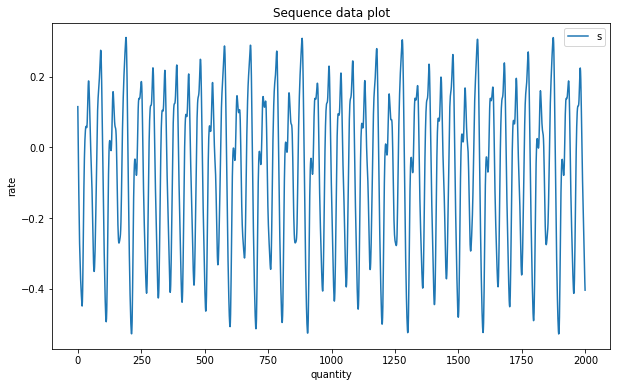

In [71]:
mackey_glass = mackey_glass(sample_len=2000, tau=17, seed=None, n_samples = 1)
data = np.asarray(mackey_glass[0], dtype=theano.config.floatX)

# Plotting the data
plt.figure(figsize=(10,6))
plt.plot(data)
plt.title('Sequence data plot')
plt.xlabel('quantity')
plt.ylabel('rate')
plt.legend('s')
plt.show()

# Splitting train and test data 
data_train = data[:1500]
data_val = data[1500:]

# Initialize Parameters

In [72]:
input_dim = 1
recurrent_dim = 15


# Initalize
w_xh = np.random.normal(0, .01,(input_dim, recurrent_dim))
w_hh = np.random.normal(0, .02, (recurrent_dim, recurrent_dim))

w_xr = np.random.normal(0, .01,(input_dim, recurrent_dim))
w_hr = np.random.normal(0, .02, (recurrent_dim, recurrent_dim))

w_xz = np.random.normal(0, .01,(input_dim, recurrent_dim))
w_hz = np.random.normal(0, .02, (recurrent_dim, recurrent_dim))


# Create shared variables 
b_h = theano.shared(np.zeros((recurrent_dim,), dtype=floatX), name="b_h")
b_r = theano.shared(np.zeros((recurrent_dim,), dtype=floatX), name="b_r")
b_z = theano.shared(np.zeros((recurrent_dim,), dtype=floatX), name="b_z")

h0  = theano.shared(np.zeros((recurrent_dim,), dtype=floatX), name="h0")
parameters = [w_xh, w_hh, b_h, w_xr, w_hr, b_r, w_xz, w_hz, b_z, h0]


# Incorporating prior distributions to GRU network to make it Bayesian GRU network

In [73]:
with pm.Model() as model:
    
    # Incorporating prior distributions to GRU network weights
    #Update
    weight_xz = pm.Normal('w_xz', 0, sd=1,
                    shape=(input_dim, recurrent_dim),
                     testval=w_xz)


    weight_hz = pm.Normal('w_hz', 0, sd=1,
                    shape=(recurrent_dim, recurrent_dim),
                     testval=w_hz)

    # Reset
    weight_xr = pm.Normal('w_xr', 0, sd=1,
                    shape=(input_dim, recurrent_dim),
                     testval=w_xr)

    weight_hr = pm.Normal('w_hr', 0, sd=1,
                    shape=(recurrent_dim, recurrent_dim),
                     testval=w_hr)

    # H_tilda
    weight_xh = pm.Normal('w_xh', 0, sd=1,
                    shape=(input_dim, recurrent_dim),
                     testval=w_xh)

    weight_hh = pm.Normal('w_hh', 0, sd=1,
                    shape=(recurrent_dim, recurrent_dim),
                          testval=w_hh)
    
    # GRU network equations 
    
    def _step(input_t, previous):
        r = T.nnet.sigmoid(input_t.dot(weight_xr) + previous.dot(weight_hr) + b_r)
        z = T.nnet.sigmoid(input_t.dot(self.weight_xz) + previous.dot(self.weight_hz) + b_z)
        hhat = T.tanh(input_t.dot(weight_xh) + (r * previous).dot(weight_hh) + b_h)
        h = (1 - z) * previous + z * hhat
        
        
        return h 
    
    
    def __call__(x):
        x_w_xh = T.dot(x, w_xh) + b_h 
        result, updates = theano.scan(_step,
                                     sequences=[x_w_xh],
                                     outputs_info=[h0],
                                     n_steps=x.shape[0])
        
     
        
        return result
    

# Hamiltonian Monte Carlo (HMC)

In [74]:
with model:
    step = pm.HamiltonianMC()
    trace = pm.sample(1000, step=step)[500:]

Multiprocess sampling (2 chains in 2 jobs)
HamiltonianMC: [w_hh, w_xh, w_hr, w_xr, w_hz, w_xz]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 3000/3000 [00:08<00:00, 338.49draws/s]
The acceptance probability does not match the target. It is 0.5072307058716561, but should be close to 0.65. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000276106F0D08>,
      dtype=object)

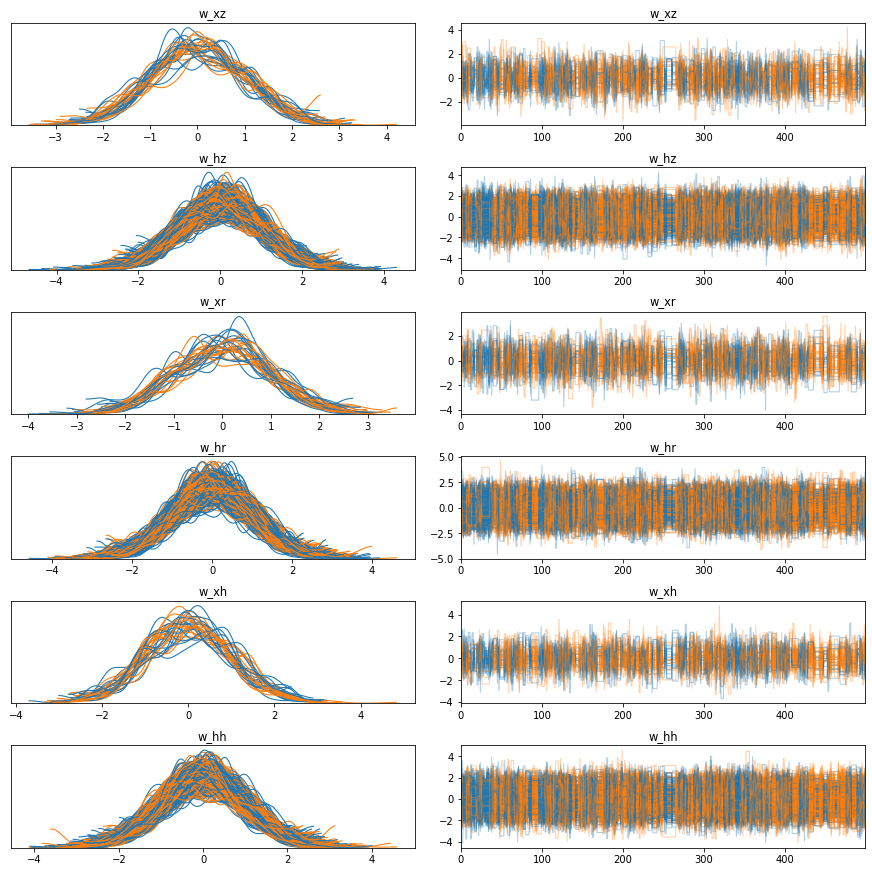

In [75]:
pm.traceplot(trace)
#traceplot displays iterations vs sampled values for each parameter, with seperate plot per parameter.
#This plot helps to judge how quickly the MCMC sampler procedure coverges in distribution

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002761A89B048>,
      dtype=object)

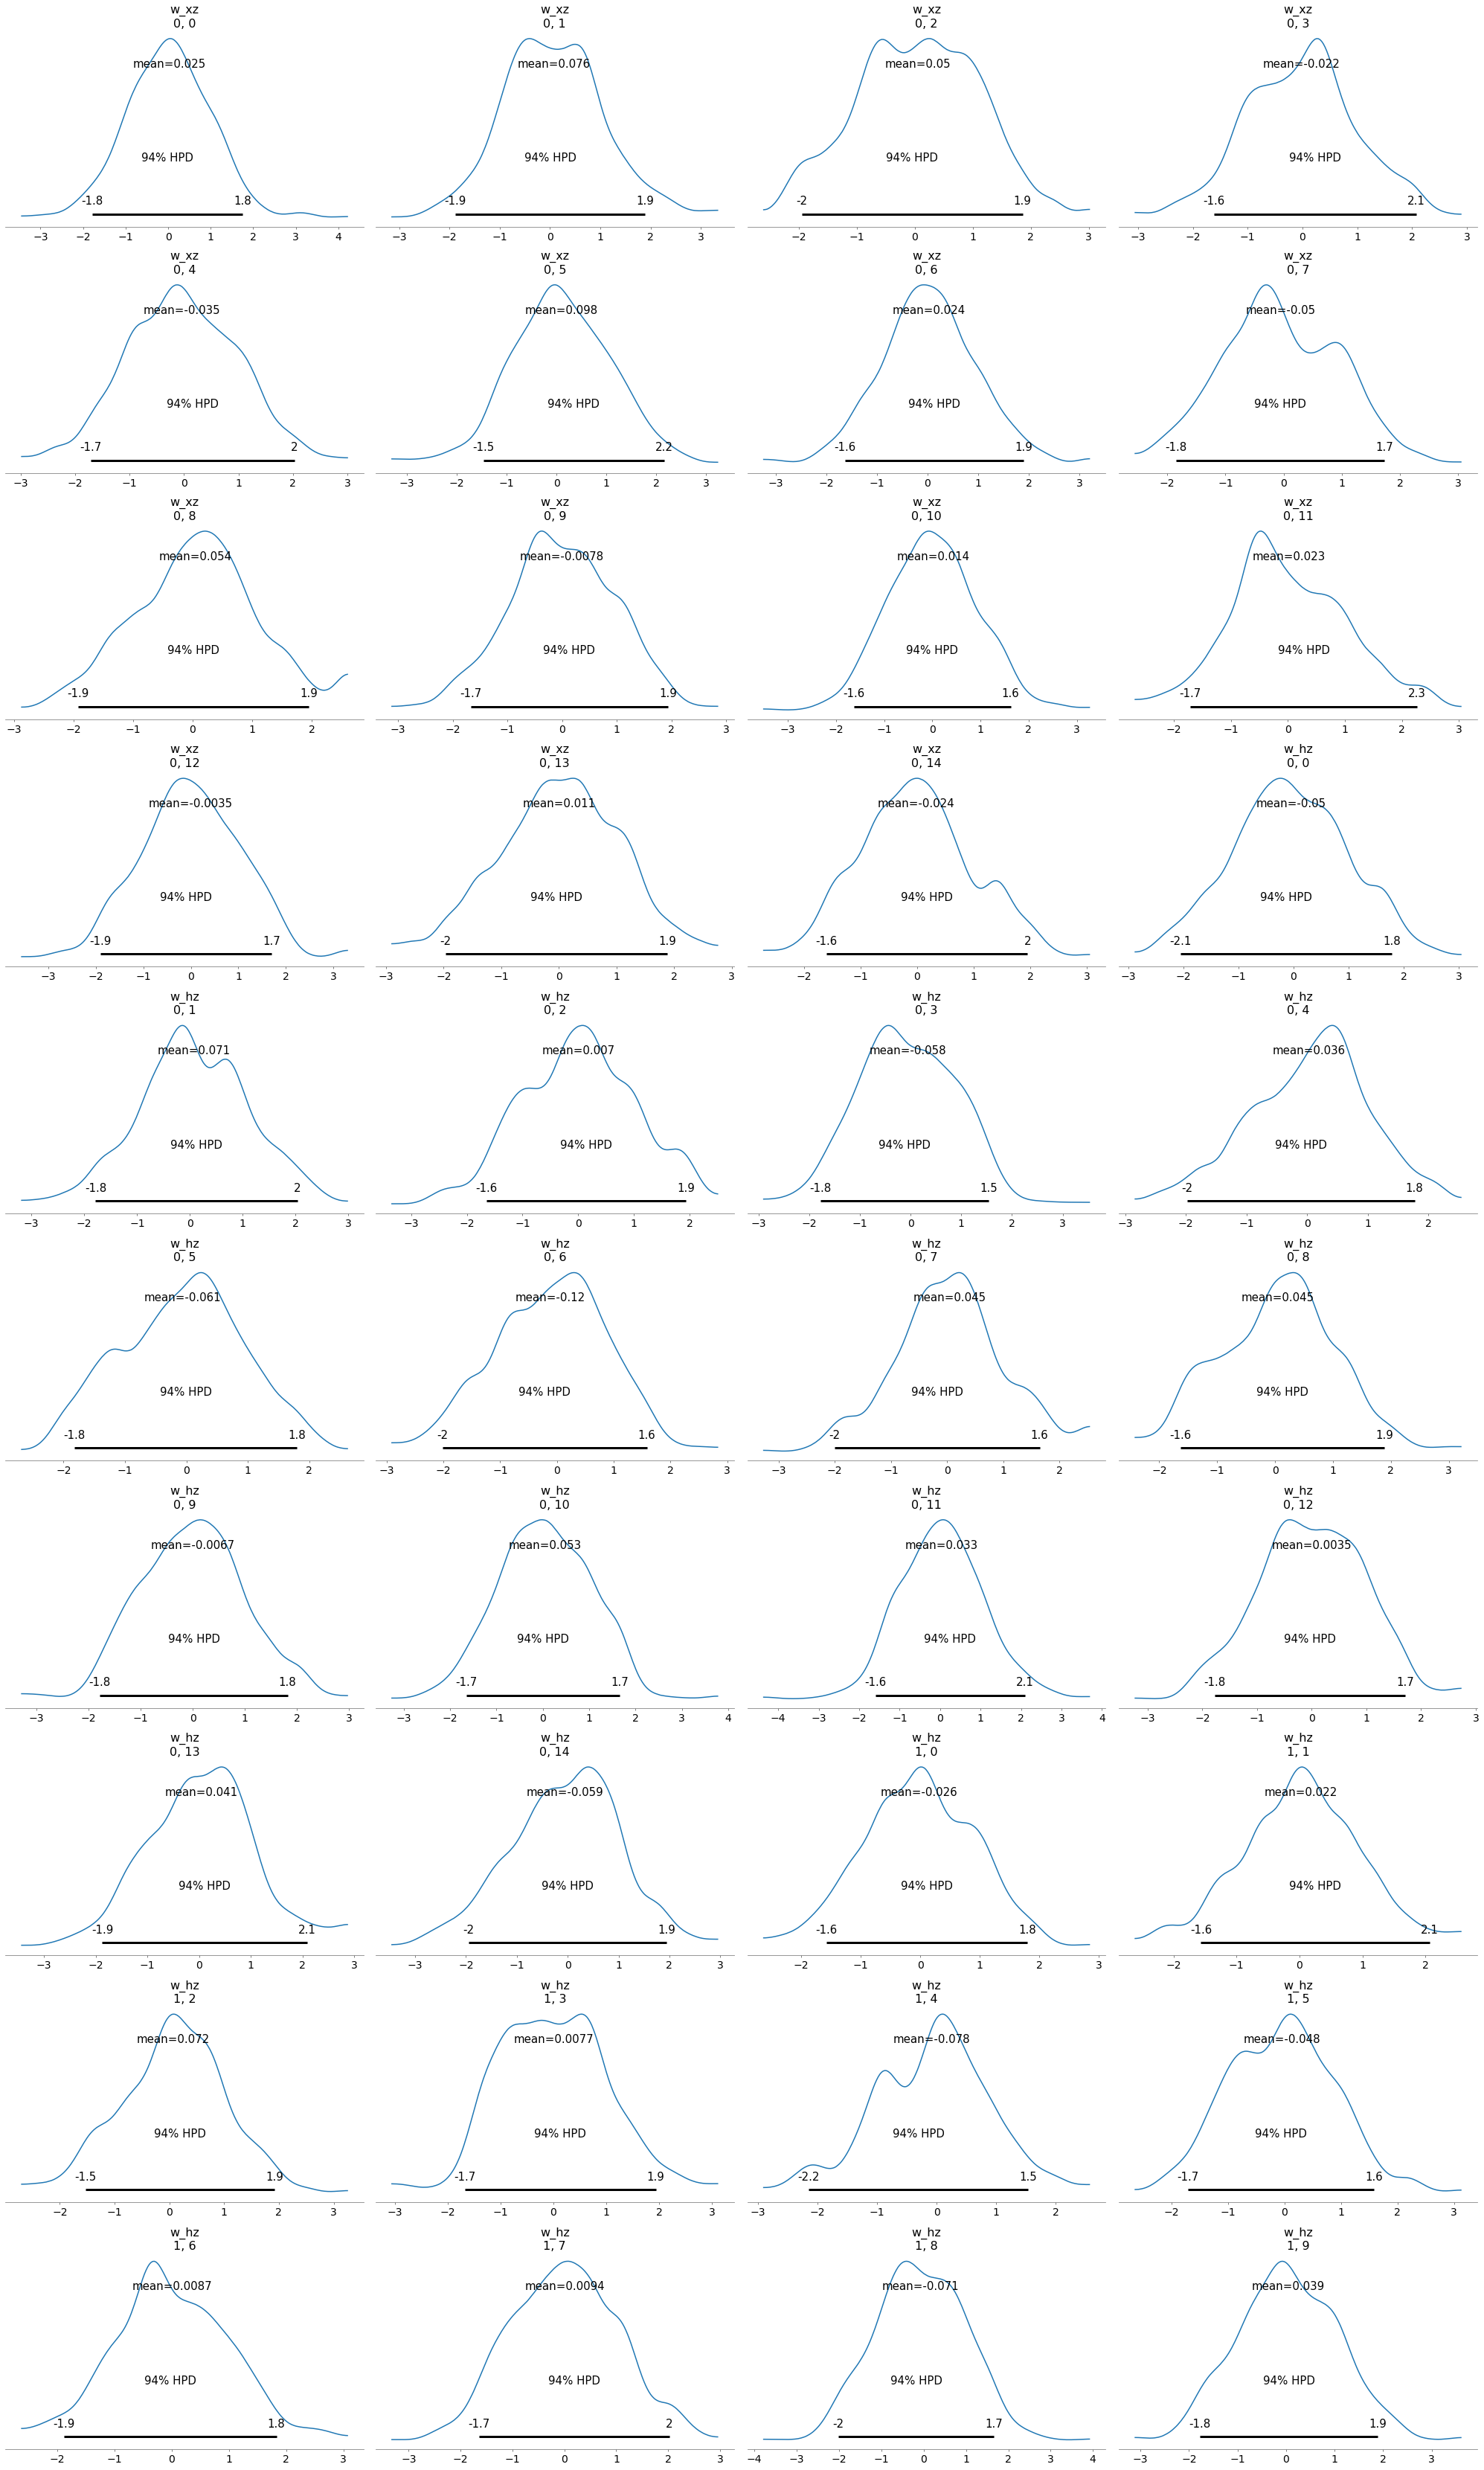

In [76]:
pm.plot_posterior(trace)

The posterior distributions represents uncertainty after combining the info in the data (the likelihood) with what we knew before collecting the data (prior)

# No-U_Turn Sampler 

In [77]:
with model:
    step = pm.NUTS()
    trace = pm.sample(1000, step=step)[500:]

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_hh, w_xh, w_hr, w_xr, w_hz, w_xz]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 3000/3000 [00:19<00:00, 151.85draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000276282236C8>,
      dtype=object)

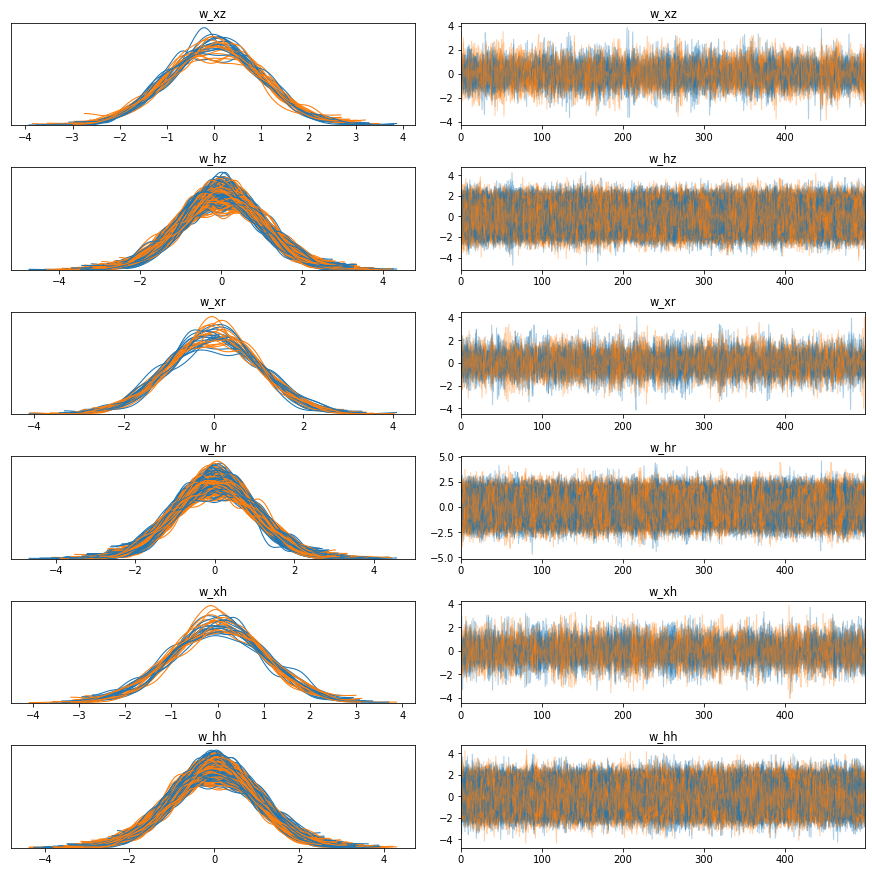

In [78]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002763406AAC8>,
      dtype=object)

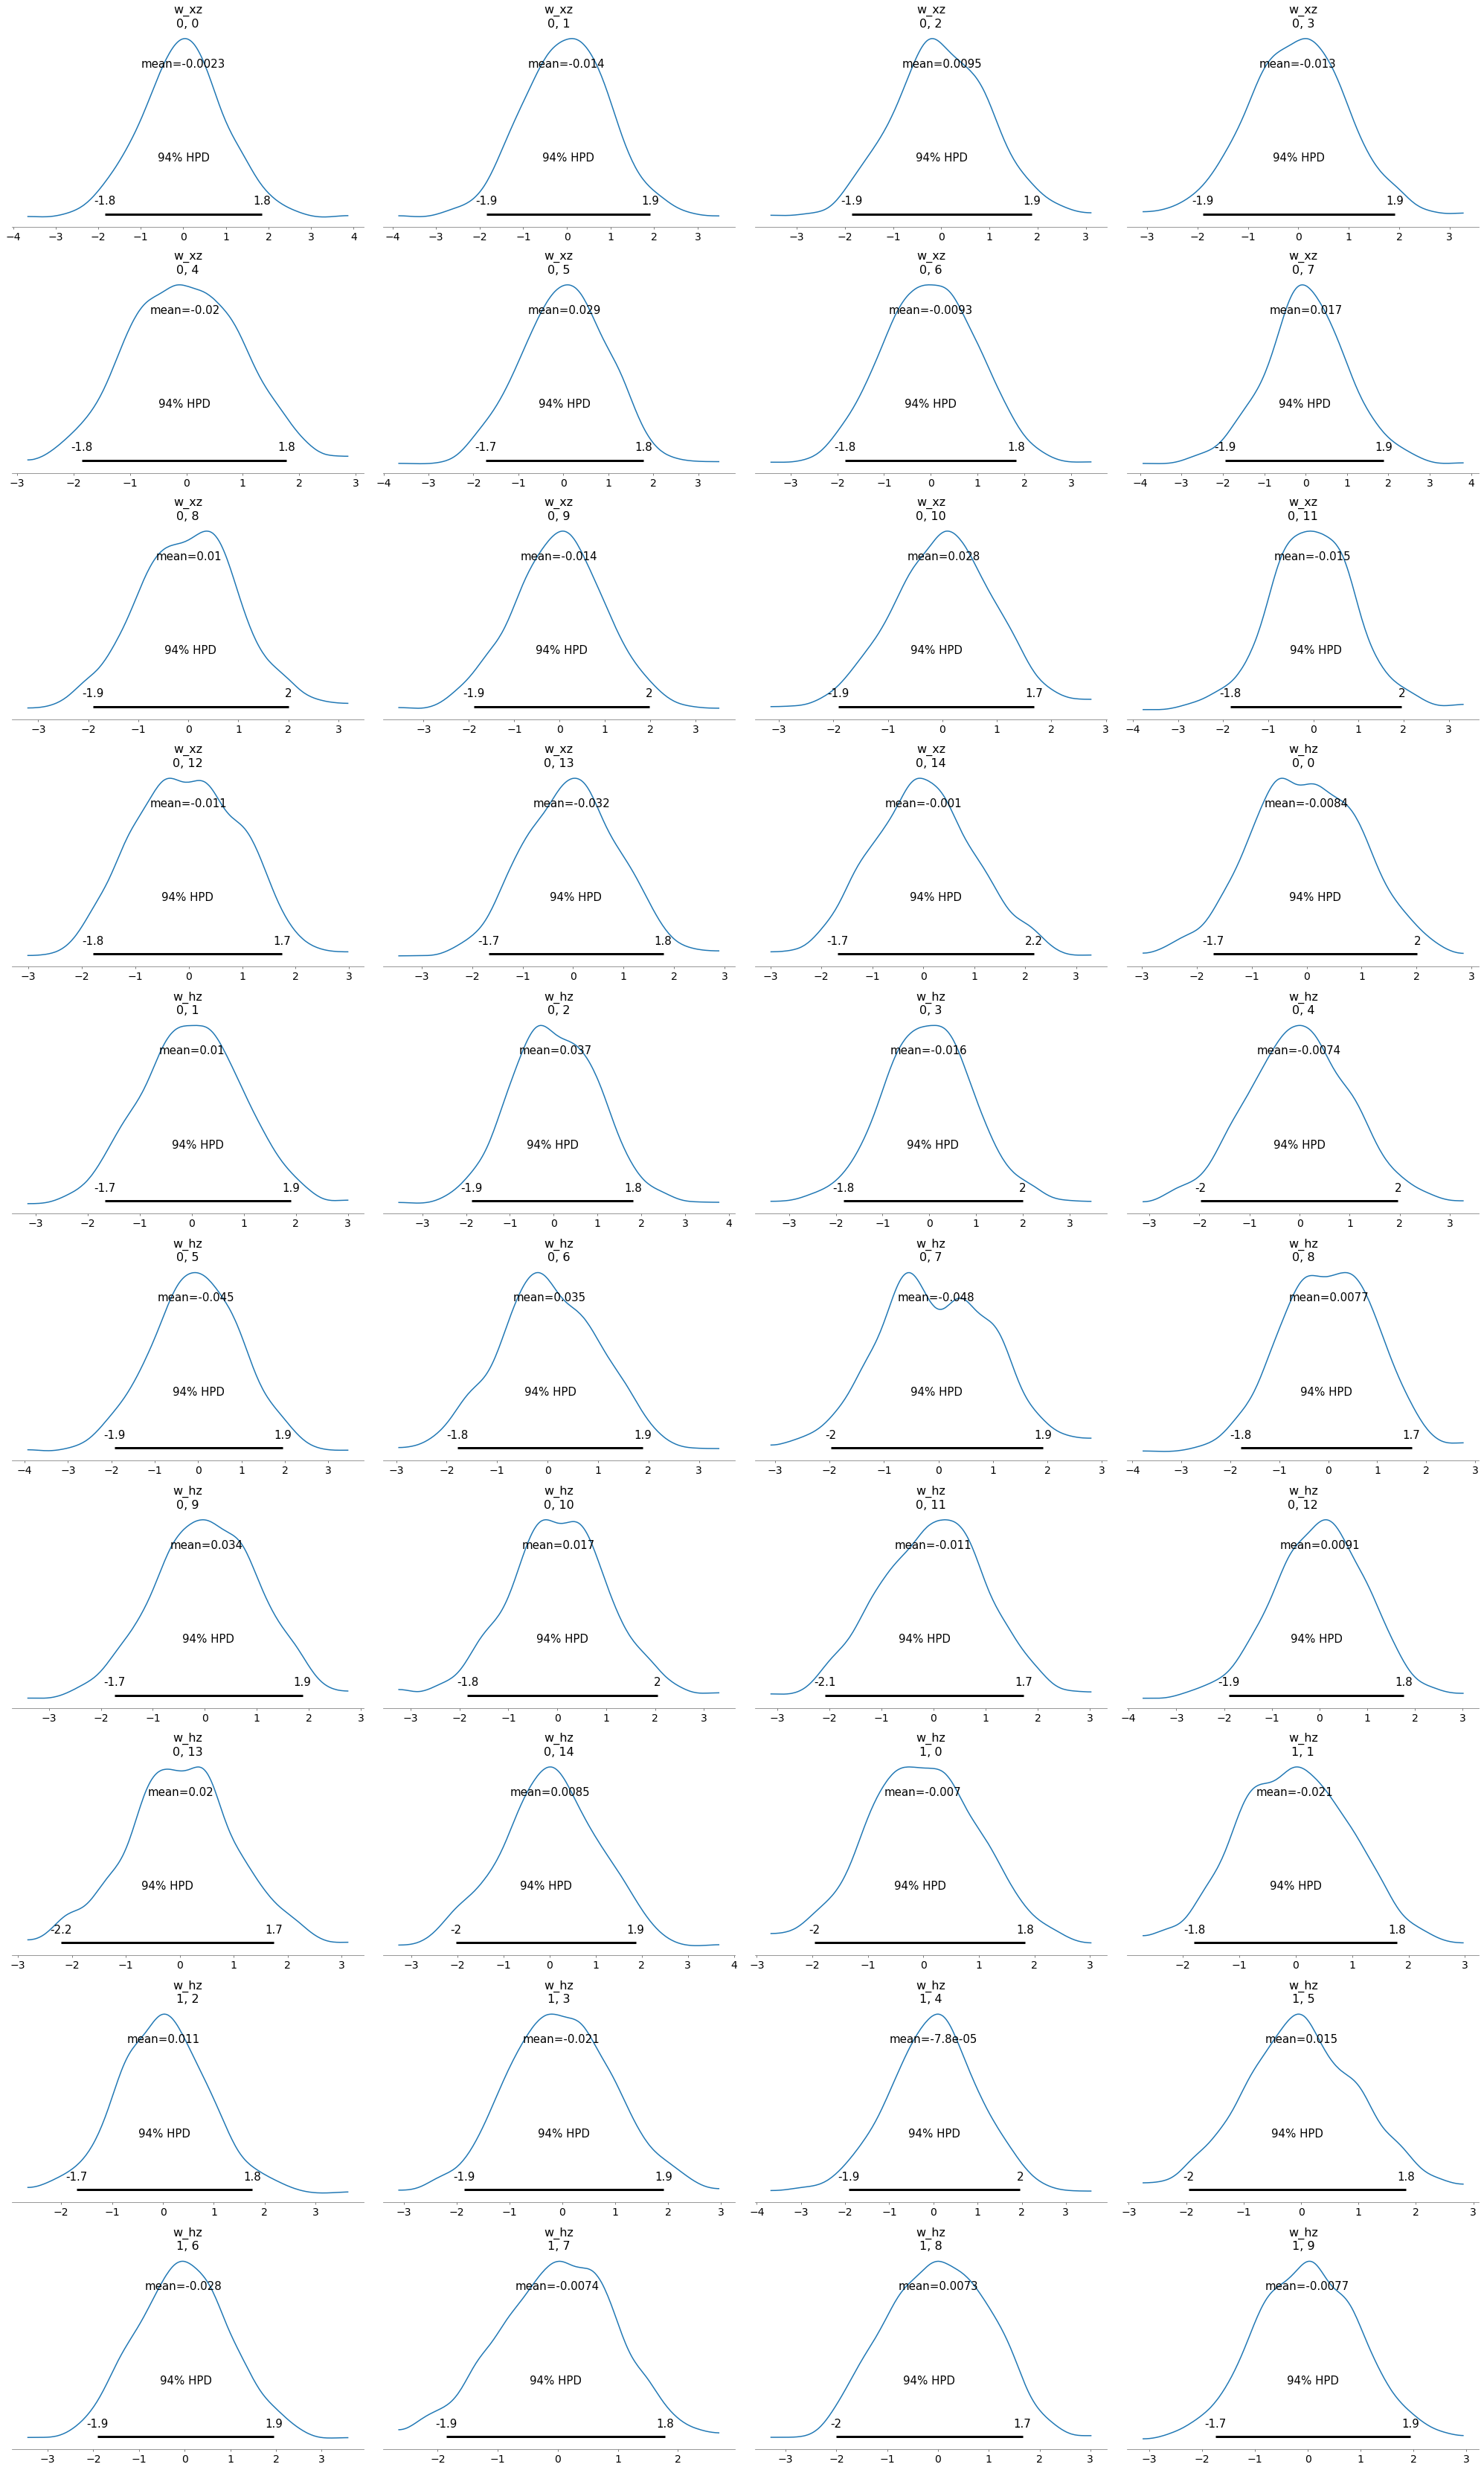

In [79]:
pm.plot_posterior(trace)